# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 3

In [1]:
from config import *
# This is needed to render the plots in this chapter
from plots.chapter3 import *

In [3]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

from stepbystep.v0 import StepByStep

# A Simple Classification Problem

## Data Generation

Let us make the data a bit more interesting by using two features (x1 and x2) this time. We will use Scikit-Learn’s make_moons method to generate a toy dataset with 100 data points. We will also add some Gaussian noise, and set a random seed to ensure reproducibility.

Then, we will perform the train-validation split using Scikit-Learn’s train_test_split method for convenience. We will get back to splitting indexes later:

In [4]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

Next, we will standardize the features using Scikit-Learn’s StandardScaler:

In [5]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

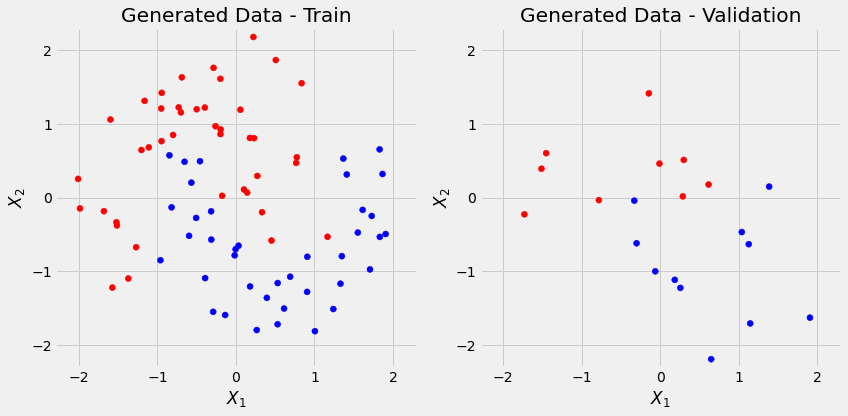

In [6]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

Hopefully, this step feels familiar to you already. As usual, the data preparation step converts Numpy arrays into PyTorch tensors, builds TensorDatasets for them, and creates the corresponding data loaders.

In [7]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Model

#### Linear regression
Well, since it is called “logistic regression,” then linear regression is a good starting point for us to build up to it. What would a linear regression model with two features look like?

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

There is one obvious problem with the model above. Our labels (y) are discrete, meaning they can be only zero or one. We need to change the model slightly to adapt it to our purposes.

“What if we assign the positive outputs to one and the negative outputs to zero?”

Makes sense, right? We are already calling them positive and negative classes anyway. Why not put their names to good use? Our model would look like this:

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

An example of this can be seen below:

In [8]:
import numpy as np

# Variables initialized
b = -1
w1, w2 = 2, 3
N = 5

# Computing linear regression
np.random.seed(42)
x1 = x2 = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = b + (w1 * x1) + (w2 * x2) + epsilon

# Mapping linear regression model to labels
results = [1 if num >= 0 else 0 for num in y]

# Displaying the results
print("Values of y:")
print(y)
print("\nLabels:")
print(results)

Values of y:
[[ 0.90060472]
 [ 3.85462306]
 [ 2.6018819 ]
 [ 1.94077544]
 [-0.27704481]]

Labels:
[1, 1, 1, 1, 0]


### Logits

To make our lives easier, let us give a name to the right-hand side of the equation above: logit (z).

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

The equation above is strikingly similar to the original linear regression model, but we are calling the resulting value “z” or “logit” instead of y or “label.”

An example of this can be seen below:

In [9]:
import numpy as np

# Variables initialized
b = -1
w1, w2 = 2, 3
N = 5

# Computing logits
np.random.seed(42)
x1 = x2 = np.random.rand(N, 1)
z = b + (w1 * x1) + (w2 * x2)

# Displaying the results
print("Values of z:")
print(z)

Values of z:
[[ 0.87270059]
 [ 3.75357153]
 [ 2.65996971]
 [ 1.99329242]
 [-0.2199068 ]]


### Probabilities

If a data point has a logit that equals zero, it is exactly at the decision boundary since it is neither positive nor negative. We assigned it to the positive class for the sake of completeness, but this assignment has maximum uncertainty. So, the corresponding probability needs to be 0.5 (50%), since it could go either way.

Following this reasoning, we would like to have large positive logit values assigned to higher probabilities (of being in a positive class) and large negative logit values assigned to lower probabilities (of being in a positive class).

For really large positive and negative logit values (z), we would like to have:

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

We still need to figure out a function that maps logit values into probabilities. We will get there soon enough. But first, we need to talk about “odds ratio.”

### Odds Ratio

The odds ratio is given by the ratio between the probability of success (p) and the probability of failure (q):

$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$

In code, our odds_ratio function looks like this:

In [10]:
def odds_ratio(prob):
    return prob / (1 - prob)

p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

We can also plot the resulting odds ratios for probabilities ranging from 1% to 99%. The red dots correspond to the probabilities of 25% (q), 50%, and 75% (p).

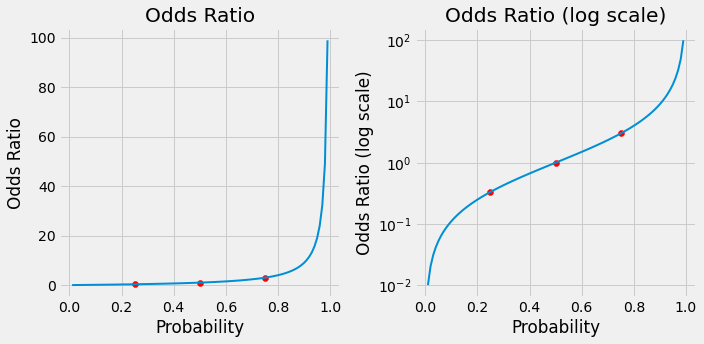

In [11]:
fig = figure2(p)

Clearly, the odds ratios (left plot) are not symmetrical. But, in a log scale (right plot), they are. This serves us very well since we are looking for a symmetrical function that maps logit values into probabilities.

### Log Odds Ratio

By taking the logarithm of the odds ratio, the function is not only symmetrical, but it also maps probabilities into real numbers instead of only the positive ones:

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

In code, our log_odds_ratio function looks like this:

In [12]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

As expected, probabilities that add up to 100% (like 75% and 25%) correspond to log odds ratios that are the same in absolute value. Let us plot it:

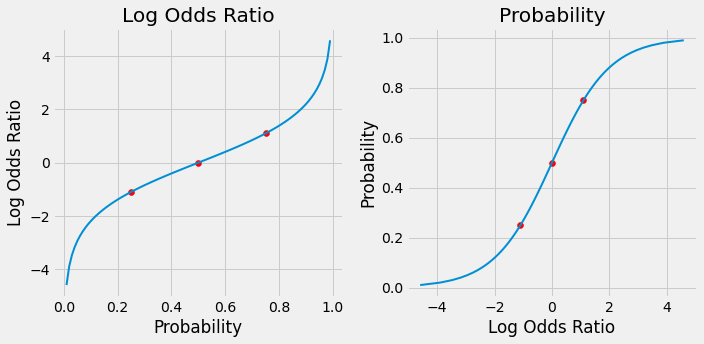

In [13]:
fig = figure3(p)

On the left, each probability maps into a log odds ratio. The red dots correspond to probabilities of 25%, 50%, and 75%, which is the same as before.

If we flip the horizontal and vertical axes (right plot), we are inverting the function, thus mapping each log odds ratio into a probability. That is precisely the function we were looking for!

Does its shape look familiar?

### From Logits to Probabilities

In the previous lesson, we were trying to map logit values into probabilities, and we have just found, graphically, a function that maps log odds ratios into probabilities.

Clearly, our logits are log odds ratios. Sure, concluding this is not very scientific, but the purpose of this exercise is to illustrate how the results of a regression, represented by the logits (z), get to be mapped into probabilities.

So, that is where we arrived at:

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

Let us work this equation out a bit, inverting, rearranging, and simplifying some terms to isolate p:

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

Does it look familiar? That is a sigmoid function! It is the inverse of the log odds ratio, which has the following equation:

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

The code for this is given below as well:

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

### Sigmoid

There is no need to implement our own sigmoid function though. PyTorch provides two different ways of using a sigmoid: torch.sigmoid and nn.Sigmoid.

The first one is a simple function, like the one above. But instead, it takes a tensor as input and returns another tensor:

In [14]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

Plotting this gives us the following result:

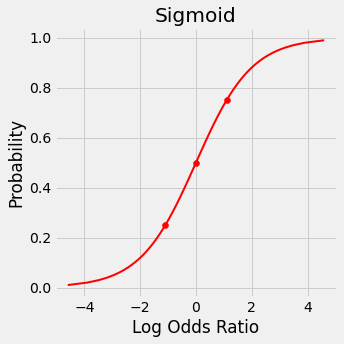

In [15]:
fig = figure4(p)

The second one is a full-fledged class inherited from nn.Module. It is, for all intents and purposes, a model on its own. However, it is quite a simple and straightforward model, as it only implements a forward method, which (surprise, surprise) calls torch.sigmoid.

### Logistic Regression

Logistic regression is a type of model in which (given two features of x1 and x2) the model will fit a linear regression such that its outputs are logits (z), which are converted into probabilities using a sigmoid function. This will have the following equation:

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

A picture is worth a thousand words, so let us visualize it:

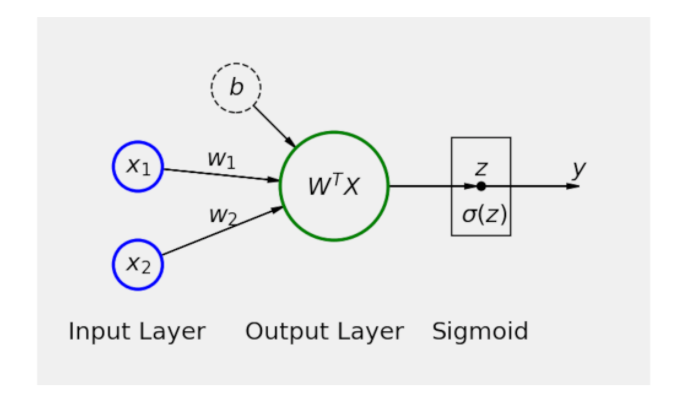

We can think of logistic regression as the second simplest neural network possible. It is pretty much the same as the linear regression but with a sigmoid applied to the results of the output layer (z).

Now keeping this in mind, let us use the Sequential model to build our logistic regression in PyTorch:

In [16]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


Did you notice that the state_dict contains parameters from the linear layer only? Even though the model has a second sigmoid layer, this layer does not contain any parameters since it does not need to learn anything. The sigmoid function will be the same regardless of which model it is a part of.

### A Note on Notation

So far, we have handled either one feature (up to the chapter, Rethinking the Training Loop) or two features (this chapter). It allowed us to spell equations out, listing all terms.

But the number of features can easily increase if we start tackling inputs like images. So we need to agree on a notation for vectorized features. Actually, if you observe the logistic regression figure given above, you can clearly see we already are using it there.

The vectorized representations of the weights (W) and features (X), therefore, are:

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

As shown in the logistic regression figure, the logits (z) are given by the expression below:

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

From now on, instead of using the final and long expression, we will use the first and more concise one.

## Loss

We already have a model, and now we need to define an appropriate loss for it. A binary classification problem calls for the binary cross-entropy (BCE) loss, which is sometimes known as log loss.

The BCE loss requires the predicted probabilities, as returned by the sigmoid function, and the true labels (y) for its computation. For each data point i in the training set, it starts by computing the error corresponding to the point’s true class.

If the data point belongs to the positive class (y=1), we would like our model to predict a probability close to one, right? A perfect one would result in the logarithm of one, which is zero. It makes sense; a perfect prediction means zero loss. It goes like this:

$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

What if the data point belongs to the negative class (y=0)? Then, we cannot simply use the predicted probability. Why not? Because the model outputs the probability of a point belonging to the positive, not the negative class. Luckily, the latter can be easily computed:

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

And thus, the error associated with a data point belonging to the negative class goes like this:

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

Once all errors are computed, they are aggregated into a loss value.

### Binary cross-entropy loss

For the binary cross-entropy loss, we simply take the average of the errors and invert its sign. This will have the following equation:

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

Let us assume we have two dummy data points, one for each class. Then, let us pretend our model made predictions for them: 0.9 and 0.2. The predictions are not bad since it predicts a 90% probability of being positive for an actual positive and only 20% of being positive for an actual negative. What does this look like in code? Here it is:

In [17]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

The first summation adds up the errors corresponding to the points in the positive class. The second summation adds up the errors corresponding to the points in the negative class. The formula above is quite straightforward and easy to understand. Unfortunately, it is usually skipped over, and only its equivalent is presented:

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

The formula above is a clever way of computing the loss in a single expression, but the split of positive and negative points is less obvious. If you pause for a minute, you will realize that points in the positive class (y=1) have its second term equal to zero, while points in the negative class (y=0) have its first term equal to zero.

Let us see how it looks like in code:

In [18]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

### BCELoss

Sure enough, PyTorch implements the binary cross-entropy loss, [nn.BCELoss]. Just like its regression counterpart, MSELoss (introduced in the chapter, **A Simple Regression Problem**), it is a higher-order function that returns the actual loss function.

The **BCELoss** higher-order function takes two optional arguments (the others are deprecated, and you can safely ignore them):

- `reduction`: It takes either mean, sum, or none. The default mean corresponds to our equation 6.15 in the previous lesson. As expected, sum will return the sum of the errors instead of the average. The last option, none, corresponds to the unreduced form; that is, it returns the full array of errors.

- `weight`: The default is none. Meaning, every data point has equal weight. If informed, it needs to be a tensor with a size that equals the number of elements in a mini-batch, representing the weights assigned to each element in the batch. In other words, this argument allows you to assign different weights to each element of the current batch based on its position. So, the first element would have a given weight, the second element would have a different weight, and so on. This is regardless of the actual class of that particular data point. Sounds confusing? Weird? Yes, this is weird. Of course, this is not useless or a mistake, but the proper usage of this argument is a more advanced topic and outside the scope of this course.

We will be sticking with the default arguments, corresponding to Equation 6.15 in the previous lesson.

In [19]:
loss_fn = nn.BCELoss(reduction='mean')

loss_fn

BCELoss()

As expected, BCELoss returned another function: the actual loss function. The latter takes both predictions and labels to compute the loss.

> IMPORTANT: Make sure to pass the predictions first and then the labels to the loss function. The order matters in the implementation of this loss function, but it matters differently from the mean squared error.

Let’s check this out:

In [20]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


Clearly, the order matters. It matters because the BCELoss takes the logarithm of the probabilities, which is expected as the first argument. If we swap the arguments, it will yield different results. In the chapter, A Simple Regression Problem, we followed the same convention when using MSELoss (first predictions, then labels) even though it would not make any difference there.

So far, so good. But there is yet another binary cross-entropy loss available, and it is very important to know when to use one or the other, so you do not end up with an inconsistent combination of model and loss function. Moreover, you will understand why we made such a fuss about the logits.

### BCEWithLogitsLoss

The former loss function took probabilities as an argument (together with the labels, obviously). This loss function takes logits as an argument instead of probabilities.

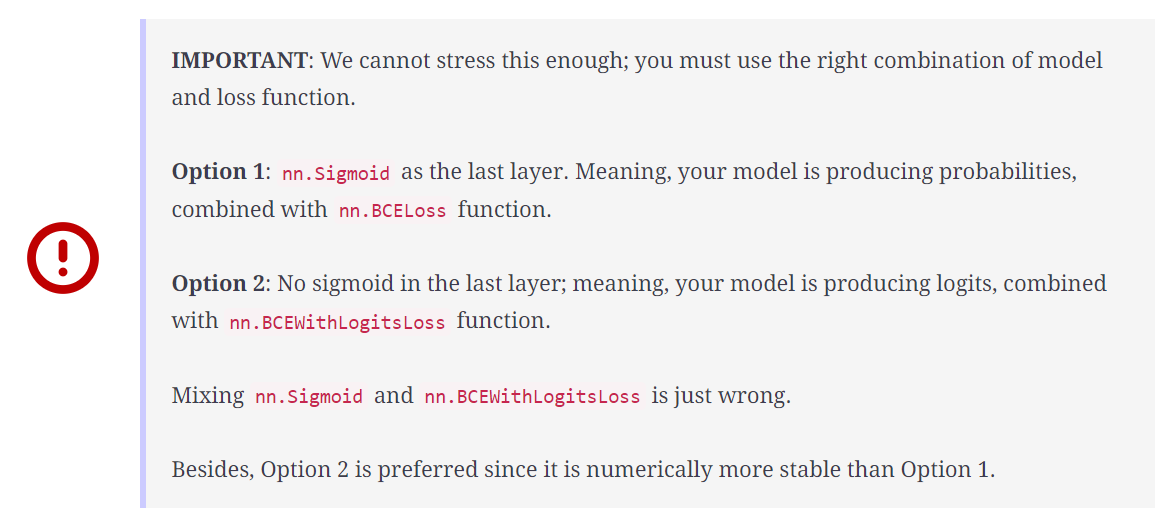

Now that the difference in the arguments is clear, let us take a closer look at the `nn.BCEWithLogitsLoss` function. It is also a higher-order function, but it takes three optional arguments. The others are deprecated, and you can safely ignore them:

- `reduction`: It takes either `mean`, `sum`, or `none`, and it works just like in nn.BCELoss. The default is `mean`.

- `weight`: This argument also works just like in nn.BCELoss, and it is unlikely to be used.

- `pos_weight`: The weight of positive samples; it must be a tensor with length equal to the number of labels associated with a data point (the documentation refers to classes instead of labels, which just makes everything even more confusing).

> You can use this argument to handle imbalanced datasets, but there is more to it than meets the eye. We will get back to it in the next lesson.

Enough talking (or writing!). Let us see how to use this loss in code. We start by creating the loss function itself:

In [21]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

Next, we use logits and labels to compute the loss. Following the same principle as before, it should be logits first, then labels. To keep the example consistent, let us get the values of the logits corresponding to the probabilities we used before: 0.9 and 0.2 by using our log_odds_ratio function:

In [22]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


We have both the logits and the labels. Time to compute the loss:

In [23]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

### Imbalanced Dataset

In our dummy example with two data points, we had one of each class: positive and negative. The dataset was perfectly balanced. Let us create another dummy example with an imbalance, adding two extra data points belonging to the negative class. For the sake of simplicity and to illustrate a **quirk** in the behavior of `BCEWithLogitsLoss`, we will give those two extra points the same logits as the other data points in the negative class. It looks like this:

In [24]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

Clearly, this is an imbalanced dataset. There are three times more data points in the negative class than in the positive one.

### The pos_weight argument

Now, let us turn to the pos_weight argument of BCEWithLogitsLoss. To compensate for the imbalance, one can set the weight equals the ratio of negative to positive examples:

$$
\Large \text{pos_weight} = \frac{\text{# points in negative class}}{\text{# points in positive class}}
$$

In our imbalanced dummy example, the result would be 3.0. This way, every point in the positive class would have its corresponding loss multiplied by three. Since there is a single label for each data point (c = 1), the tensor used as an argument for pos_weight has only one element: tensor([3.0]). We could compute it like this:

In [25]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

Now, let us create yet another loss function, including the `pos_weight` argument this time:

In [26]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

Then, we can use this weighted loss function to compute the loss for our imbalanced dataset. I guess one would expect the same loss as before; after all, this is a weighted loss. Right?

In [27]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

Wrong! It was 0.1643 when we had two data points, one of each class. Now it is 0.2464 even though we assigned a weight to the positive class.

### Weighted average

Well, it turns out, PyTorch does not compute a weighted average. That is what you would expect from a weighted average:

$$
\Large \text{weighted average} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{\text{pos_weight} N_{\text{pos}}+N_{\text{neg}}}
$$

This is what PyTorch does:

$$
\Large \text{BCEWithLogitsLoss} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{N_{\text{pos}}+N_{\text{neg}}}
$$

See the difference in the denominator? Of course, if you multiply the losses of the positive examples without multiplying their count (N), you will end up with a number larger than an actual weighted average.

An example of this can be seen below:

In [28]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration

In the chapter, Going Classy, we ended up with a lean model configuration part. We only need to define a model, an appropriate loss function, and an optimizer. Let us define a model that produces logits and uses BCEWithLogitsLoss as the loss function. Since we have two features, and we are producing logits instead of probabilities, our model has one layer and one layer alone: Linear(2, 1). We will keep using the SGD optimizer with a learning rate of 0.1 for now.

This is what the model configuration looks like for our classification problem:

In [29]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

## Model Training

Time to train our model! We can leverage the StepByStep class we built in the chapter, Going Classy and use pretty much the same code as before:

In [31]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

After training our model, if we try plotting our results, we get the following training and validation losses:



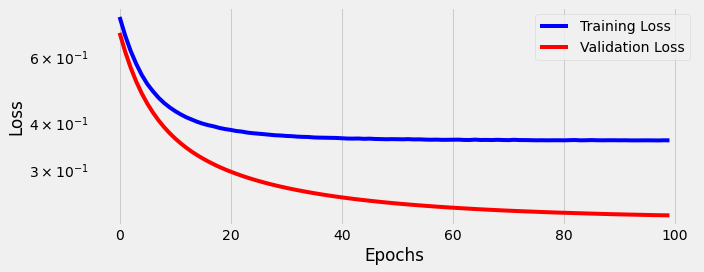

In [32]:
fig = sbs.plot_losses()

In [33]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]], device='cuda:0')), ('linear.bias', tensor([-0.0591], device='cuda:0'))])


Our model produced logits, right? So we can plug the weights above in the corresponding logit equation (equation 6.3), and we end up with:

$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0587 & + & 1.1822x_1 & - & 1.8684x_2
\end{array}
$$

The value z above is the output of our model. It is a “glorified linear regression.” And this is a classification problem! How come? Hold that thought; it will become more clear in the next lesson.

#### Making Predictions (Logits)

But, before going down that road, let’s use our model (and the StepByStep class) to make predictions for the first four data points in our training set:

In [34]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345592],
       [ 2.944445  ],
       [ 3.6933174 ],
       [-1.2334073 ]], dtype=float32)

Clearly, these are not probabilities, right? These are logits as expected.

We can still get the corresponding probabilities though.

#### Making Predictions (Probabilities)

In [33]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5504593 ],
       [0.94999564],
       [0.9757515 ],
       [0.22519748]], dtype=float32)

#### Making Predictions (Classes)

Now we are talking! These are the probabilities, given our model, of those four points being positive examples.

Lastly, we need to go from probabilities to classes. If the probability is greater than or equal to a threshold, it is a positive example. If it is less than the threshold, it is a negative example. Simple enough. The trivial choice of a threshold is 0.5:

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

But the probability itself is just the sigmoid function applied to the logit (z):

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

But the sigmoid function has a value of 0.5 only when the logit (z) has a value of zero:

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

Thus, if we do not care about the probabilities, we could use the predictions (logits) directly to get the predicted classes for the data points:

In [36]:
classes = (predictions >= 0).astype(int)
classes

array([[1],
       [1],
       [1],
       [0]])

Clearly, the points where the logits (z) equal zero determine the boundary between positive and negative examples.

## Decision Boundary

We have just figured out that whenever z equals zero, we are in the decision boundary. But z is given by a linear combination of features x1 and x2. If we work out some basic operations, we arrive at:

$$
\Large
\begin{array}{ccccccccc}
z & = &   0 & =   & b & + & w_1x_1 & + & w_2x_2
\\
& & -w_2x_2 & = & b & + & w_1x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - &\frac{w_1}{w_2}x_1 & &
\end{array}
$$

Given our model (b, w1, and w2), for any value of the first feature (x1), we can compute the corresponding value of the second feature (x2) that sits exactly at the decision boundary.

> Look at the expression above; this is a straight line. It means the decision boundary is a straight line.

Let us plug the weights of our trained model in it:

$$
\Large
\begin{array}{ccccccccc}
& & x_2 & = & -\frac{0.0587}{1.8684} & + &\frac{1.1822}{1.8684}x_1 & &
\\
& & x_2 & = & -0.0314 & + &0.6327x_1 & &
\end{array}
$$

An image is worth a thousand words, right? Let us plot it!

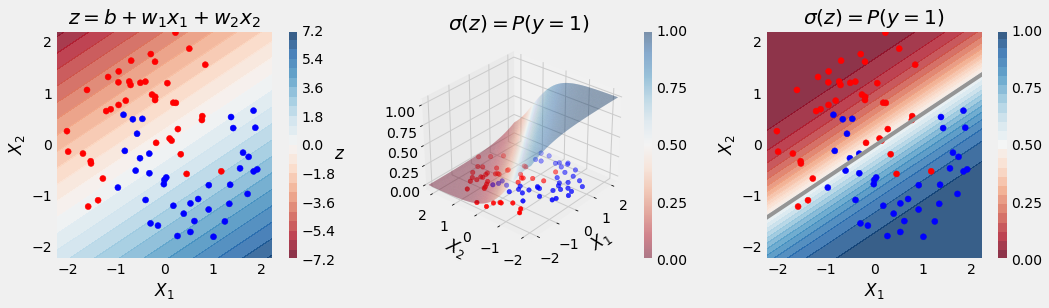

In [37]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)

The figure above tells the whole story. It contains only the data points in the training set. So, that is what the model “sees” when it is training. It will try to achieve the best possible separation between the two classes, depicted as red (negative class) and blue (positive class) points.

In the left plot, we have a contour plot (remember those from the loss surfaces in the chapter, visualizing gradient descent?) of the logits (z).

In the center plot, we have a 3D plot of the probabilities resulting from applying a sigmoid function to the logits. You can even see the shape of the sigmoid function in 3D approaching zero to the left and one to the right.

Finally, in the right plot, we have a contour plot of the probabilities, so it is the same as the center plot but without the cool 3D effect. Maybe it is not as cool, but it is surely easier to understand what is going on. Darker blue (red) colors mean higher (lower) probabilities, and we have the decision boundary as a straight gray line corresponding to a probability of 50% (and a logit value of zero).


> A logistic regression always separates two classes with a straight line.

Our model produced a straight line that does quite a good job separating red and blue points, right? Well, it was not that hard since the blue points were more concentrated on the bottom right corner, while the red points were mostly on the top left corner. In other words, the classes were quite separable.


> The more separable the classes are, the lower the loss will be.

### Validation dataset decision boundary

Now we can make sense of the validation loss being lower than the training loss. In the validation set, the classes are more separable than in the training set. The decision boundary obtained using the training set can do an even better job separating red and blue points. Let us check it out, plotting the validation set against the same contour plots as above:

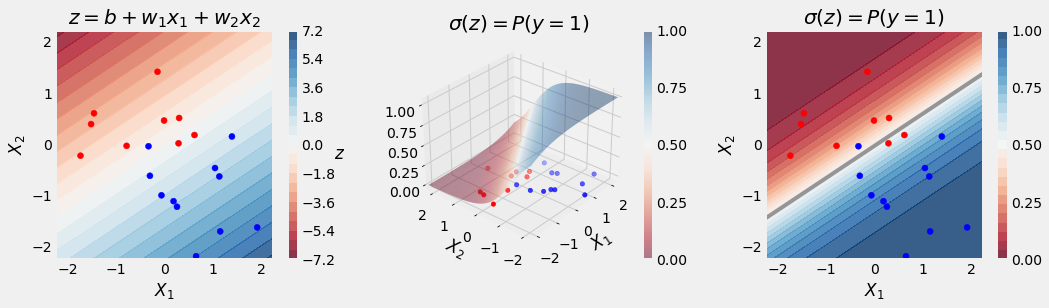

In [38]:
# Validation set
fig = figure7(X_val, y_val, sbs.model, sbs.device)

See? Apart from three points (two red and one blue), which are really close to the decision boundary, the data points are correctly classified. More separable indeed.

### Are my data points separable?

That is the million-dollar question! In the example above, we can clearly see that data points in the validation set are more separable than those in the training set.

What happens if the points are not separable at all? Let us take a quick detour, and look at another tiny dataset with 10 data points, seven red, and three blue. The colors are the labels (y), and each data point has a single feature (x1). We could plot them along a line; after all, we have only one dimension.

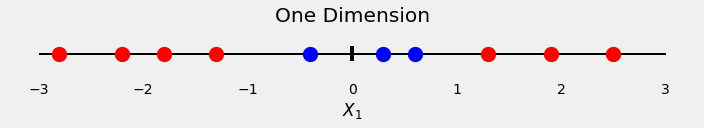

In [37]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

Can you separate the blue points from the red ones with one straight line? Obviously, not. These points are not separable (in one dimension, that is).

Should we give up, then?

If it does not work in one dimension, try using two! There is just one problem though. Where does the other dimension come from? We can use a trick here though; we apply a function to the original dimension (feature), and use the result as a second dimension (feature). Quite simple, right?

For the tiny dataset at hand, we could try the square function:

$$
\Large X_2 = f(X_1)= X_1^2
$$

How does it look now?

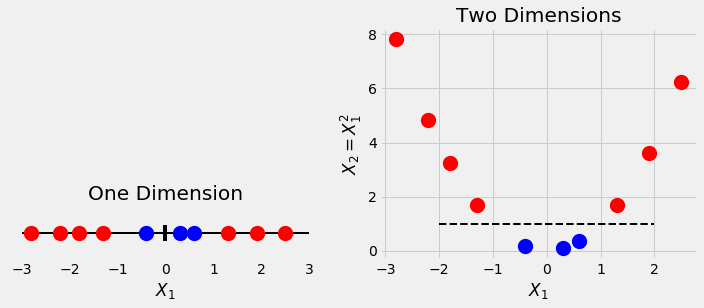

In [38]:
fig = two_dimensions(x, y)

### Effect of increasing dimensions

Back to the original question: “can you separate the blue points from the red ones with one straight line?”

In two dimensions, that is a piece of cake!

> The more dimensions, the more separable the points are.

It is beyond the scope of this course to explain why this trick works. The important thing is to understand the general idea here; as the number of dimensions increases, there is more and more empty space. If the data points are farther apart, it will likely be easier to separate them. In two dimensions, the decision boundary is a line. In three dimensions, it is a plane. In four dimensions and more, it is a hyper-plane (fancier wording for a plane you cannot draw).

Have you heard of the kernel trick for Support Vector Machines (SVMs)? That is pretty much what it does! The kernel is nothing else but the function we used to create additional dimensions. The square function we used is a polynomial, so we used a polynomial kernel.

An example of this can be seen below:

In [39]:
model = nn.Sequential()
model.add_module('hidden', nn.Linear(2, 10))
model.add_module('activation', nn.ReLU())
model.add_module('output', nn.Linear(10, 1))
model.add_module('sigmoid', nn.Sigmoid())

loss_fn = nn.BCELoss()

The model above increases dimensionality from two dimensions (two features) to ten dimensions, and then uses those ten dimensions to compute logits. But it only works if there is an activation function between the layers.

## Classification Threshold

#### Using different thresholds for classification

So far, we have been using the trivial threshold of 50% to classify our data points, given the probabilities predicted by our model. Let us dive a bit deeper into this and see the effects of choosing different thresholds.

We will be working on the data points in the validation set. There are only 20 data points in it, so we can easily keep track of all of them.

First, let us compute the logits and corresponding probabilities:

In [39]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

Then, let us visualize the probabilities on a line. It means we are going from the fancy contour plot to a simpler plot:

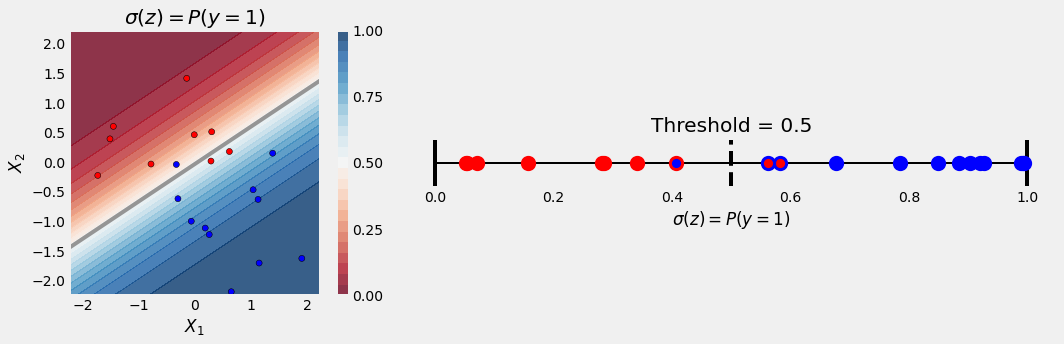

In [40]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

The left plot comes from the figure of the validation dataset in the previous lesson. It shows the contour plot of the probabilities and the decision boundary as a straight gray line. We then place the data points on a line according to their predicted probabilities. That is the plot on the right.

The decision boundary is shown as a vertical dashed line placed at the chosen threshold (0.5). Points to the left of the dashed line are classified as red, and therefore have red edges around them, while those to the right are classified as blue, having blue edges around them.

The points are filled with their actual color; meaning, those having distinct colors for edge and filling are misclassified. In the figure above, we have one blue point classified as red (left) and two red points classified as blue (right).

Now, let us make a tiny change to our plot to make it more visually interesting. We will plot blue (positive) points below the probability line and red (negative) points above the probability line. It looks like this:

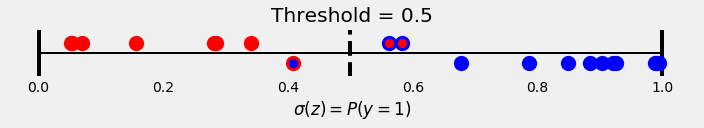

In [42]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

### Confusion Matrix

As seen in the figure above, quadrants have been introduced. Those quadrants have names: true negative (TN) and false positive (FP), above the line; false negative (FN) and true positive (TP) below the line.

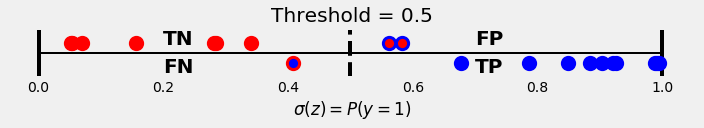

In [43]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

Points above the line are actual negatives, while points below the line are actual positives.

Points to the right of the threshold are classified as positive, while points to the left of the threshold are classified as negative.

Cool, right? Let us double-check it with Scikit-Learn’s confusion_matrix method:

In [41]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]], dtype=int64)

All 20 points in our validation set are accounted for. There are three misclassified points: one false negative and two false positives, just like in the figure above. In addition to this, we decided to move the blue points (positive) below the line to match Scikit-Learn’s convention for the confusion matrix.

In addition, we can also verify this by plotting the confusion matrix, which looks like the following:

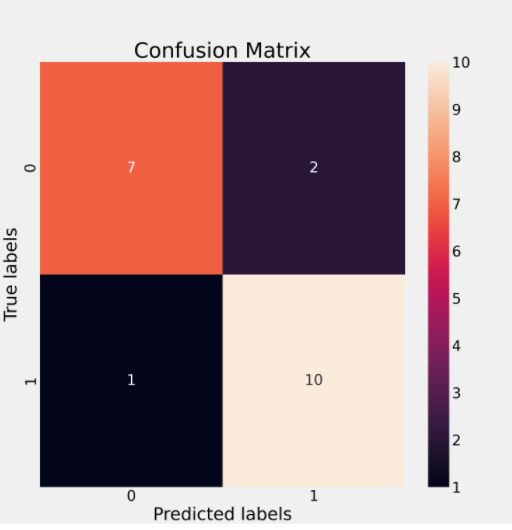

#### True and False Positives and Negatives 

There is one more thing I hope you noticed already: the confusion matrix depends on the threshold. If you shift the threshold along the probability line, you will end up changing the number of points in each quadrant.

Moreover, different confusion matrices mean different metrics. We need the individual components of the confusion matrix; namely, TN, FP, FN, and TP are needed to construct those metrics. The function below splits the confusion matrix accordingly:

In [42]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

### Metrics

#### Most commonly used metrics
Starting with these four numbers, TN, FP, FN, and TP, you may construct a ton of metrics. We are focusing here on the most commonly used: true and false-positive rates (TPR and FPR), precision, recall, and accuracy

### True and False Positive Rates

Let us start with the first two:

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

For both of them, you divide one value on the right column (positive) by the sum of the corresponding row. So, the true positive rate is computed by dividing the value on the bottom right by the sum of the bottom row. Similarly, the false positive rate is computed by dividing the value on the top right by the sum of the top row. However, what exactly do these mean?

**True positive rate** 

The true positive rate tells you, from all points you know to be positive, how many your model got right. In our example, we know there are 11 positive examples. Our model got ten right. The TPR is 10 out of 11 or roughly 91%. There is yet another name for this metric: recall. Makes sense, right? From all the positive examples, how many does your model recall?

> If false negatives are bad for your application, you need to focus on improving the **TPR/recall** metrics of your model.

> When is a false negative really bad? For example, take airport security screening where positive means the existence of a threat. False positives are common; you have nothing to hide, but your bag will eventually be more thoroughly inspected due to the extreme sensitivity of the machinery. A false-negative means that the machine failed to detect an actual threat.

**False positive rate**

The false positive rate tells you, from all points you know to be negative, how many your model got wrong. In our example, we know there are 9 negative examples. Our model got two wrong. The FPR is 2 out of 9 or roughly 22%.

> If false positives  are bad for your application, you need to focus on improving the **FPR** metric of your model.

> When is a false positive really bad? For example take an investment decision where positive means a profitable investment. False negatives are missed opportunities; they seemed like bad investments, but they were not. You did not make a profit, but you did not sustain any losses either. A false-positive means that you chose to invest but ended up losing your money.

We can use the function below (tpr_fpr) to compute both metrics, given a confusion matrix:

In [43]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [44]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

### The trade-off between TPR and FPR

As always, there is a trade-off between the two metrics.

Let us say false negatives are bad for our application, and we want to improve TPR. Here is one quick idea: let us make a model that only predicts the positive class using a threshold of zero. We have no false negatives whatsoever (because there are not any negatives in the first place). Our TPR is 100%. Awesome, right?

Wrong! If all points are predicted to be positive, every negative example will be a false positive, and there are no true negatives. Our FPR is 100% too.

There ain’t no such thing as a free lunch. The model is useless.

What if false positives are the problem instead? We would like to reduce FPR. Another brilliant idea comes to mind; let us make a model that only predicts the negative class using a threshold of one. We have no false positives whatsoever (because there are not any positives in the first place). Our FPR is 0%. Mission accomplished, right?

Guess what? Wrong again! If all points are predicted to be negative, every positive example will be a false negative, and there are no true positives. Our TPR is 0% too.

It turns out, you cannot have the cake and eat it too.

### Precision and Recall

Moving on to the next pair of metrics, we have:

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

We can skip recall because (as we mentioned above) it is the same as TPR.

What about precision? We compute it in the right column (positive) only. We divide the value on the bottom right by the sum of the right column. Its meaning is somewhat complementary to that of recall: from all points classified as positive by your model, how many did your model get right? In our example, the model classified 12 points as positive. The model got ten right. The precision is 10 out of 12 or roughly 83%.

> If false positives are bad for your application, you need to focus on improving the **precision** metric of your model.

In [45]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [46]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

#### The trade-off between precision and recall

Here, too, there is no free lunch. The trade-off is a bit different though.

Let us say false negatives are bad for our application, and we want to improve recall. Once again, let us make a model that only predicts the positive class using a threshold of zero. We have no false negatives whatsoever (because there are not any negatives in the first place). Our recall is 100%. Now you are probably waiting for the bad news, right?

If all points are predicted to be positive, every negative example will be a false positive. The precision is exactly the proportion of positive samples in the dataset.

What if false positives are the problem instead? We would like to increase precision. It is time to make a model that only predicts the negative class by using a threshold of one. We have no false positives whatsoever (because there are not any positives in the first place). Our precision is 100%.

Of course, this is too good to be true. If all points are predicted to be negative, there are no true positives. Our recall is 0%.

### Accuracy

This is the simplest and most intuitive metric: how many times your model got it right, considering all data points. Totally straightforward! It has the following formula:

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

Once again, we can use the function below (calculate_accuracy) to compute the accuracy, provided that a confusion matrix is given:

In [47]:
def calculate_accuracy(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    correct = (tp + tn)
    print("Correct:", correct) 
    total = (tp + tn + fp + fn)
    print("Total:", total, "\n")
    accuracy = correct / total
    
    return accuracy

print(calculate_accuracy(cm_thresh50))

Correct: 17
Total: 20 

0.85


In our example above, the model correctly predicted 17 points out of a total of 20 data points. Its accuracy is 85%. Not bad. The higher the accuracy, the better. However, it does not tell the whole story. If you have an imbalanced dataset, relying on accuracy can be misleading.

Let us say we have 1,000 data points. 990 points are negative, and only ten are positive. Now, let us take the model that uses a threshold of one and only predicts the negative class. This way, we get all 990 negative points right at the cost of ten false negatives. This model’s accuracy is 99%. But the model is still useless because it will never get a positive example right.

Accuracy may be misleading because it does not involve a trade-off with another metric like the previous ones.

## Trade-offs and Curves

We already know there are trade-offs between true and false-positive rates as well as between precision and recall. We also know that there are many confusion matrices, one for each threshold. What if we were to combine these two pieces of information?

We present to you the receiver operating characteristic (ROC) and precision-recall (PR) curves! Well, they are not curves yet, but they will be soon enough.

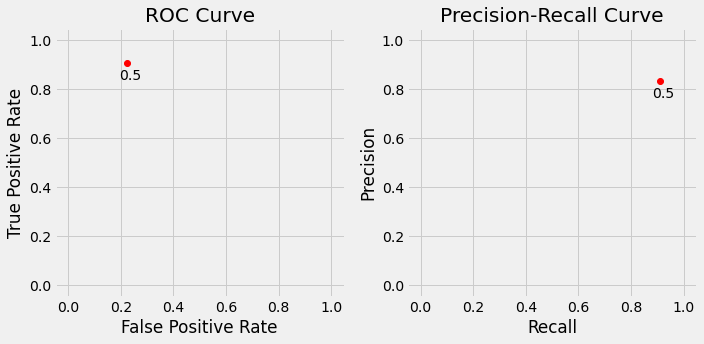

In [48]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

We have already computed the TPR/recall (91%), FPR (22%), and precision (83%) for our model using the threshold of 50%. If we plot them, we will get the figure above.

Time to try different thresholds.

### Low Threshold

What about 30%? If the predicted probability is greater than or equal to 30%, we classify the data point as positive and as negative otherwise. That is a very loose threshold since we do not require the model to be very confident to consider a data point to be positive. What can we expect from it? More false positives, less false negatives.

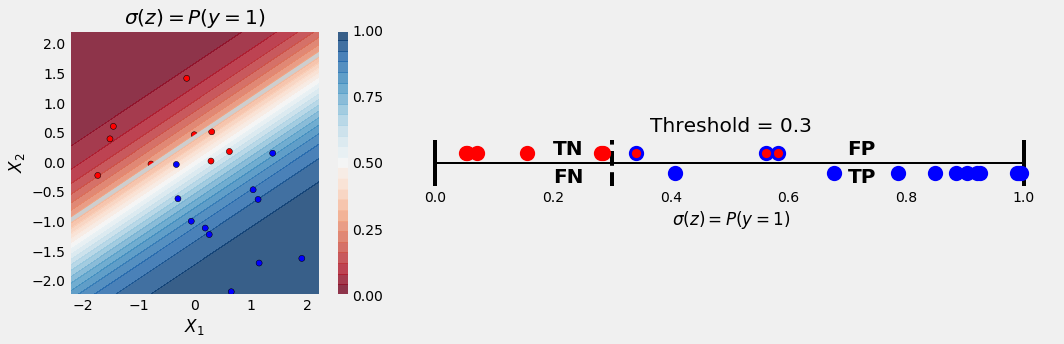

In [51]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

You can see in the figure above that lowering the threshold (moving it to the left on the probability line) turned one false negative into a true positive (blue point close to 0.4), but it also turned one true negative into a false positive (red point close to 0.4).

Let us double-check it with Scikit-learn’s confusion matrix:

In [52]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

Okay, now let us plot the corresponding metrics one more time:

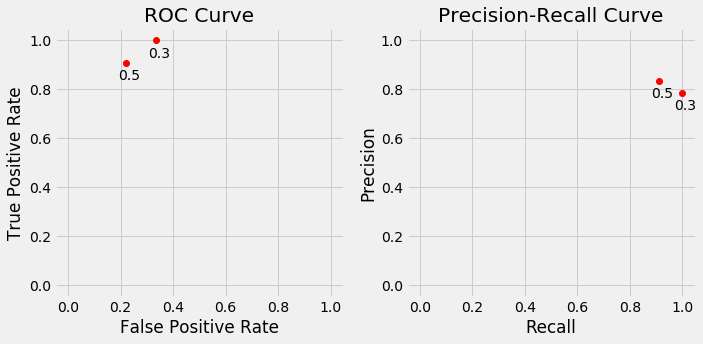

In [53]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

### High Threshold

What about 70%? If the predicted probability is greater than or equal to 70%, we classify the data point as positive and as negative otherwise. That is a very strict threshold since we require the model to be very confident to consider a data point to be positive. What can we expect from it? Less false positives, more false negatives.



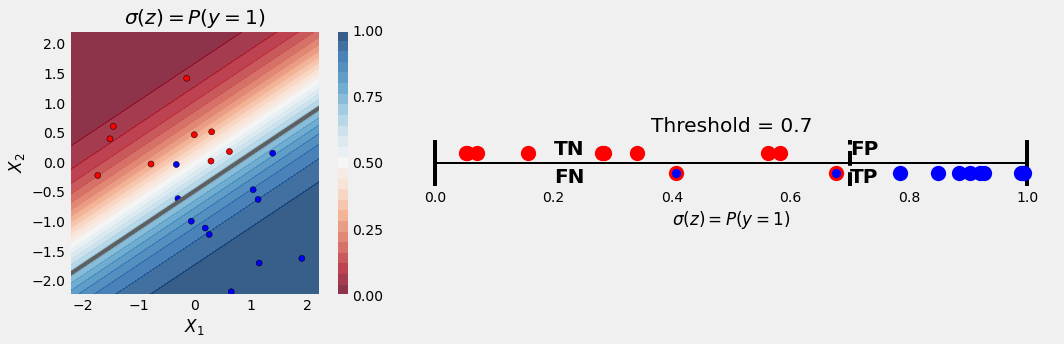

In [49]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

You can see in the figure above that raising the threshold (moving it to the right on the probability line) turned two false positives into true negatives (red points close to 0.6), but it also turned one true positive into a false negative (blue point close to 0.6).

Let us double-check it with Scikit-learn’s confusion matrix:

In [50]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]], dtype=int64)

Okay, now let us plot the corresponding metrics again:

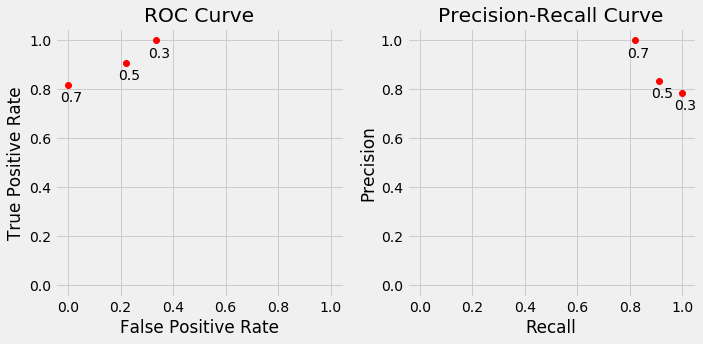

In [56]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

### ROC and PR Curves

We need to try out more thresholds to actually build a curve. Let us try multiples of 10%:

In [51]:
threshs = np.linspace(0.,1,11)

If we try plotting this, we get the following graph:

C:\Users\jobqu\OneDrive\MachineLearningHero\05_DeepLearning\PyTorch_stuff\Step_by_Step_Book\plots\chapter3.py:49: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = tp / (tp + fp)


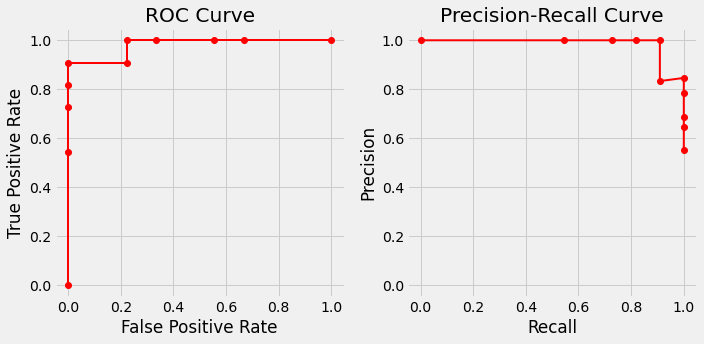

In [52]:
fig = figure17(y_val, probabilities_val, threshs)

Cool! We finally have proper curves! We have some questions for you:

- In each plot, which point corresponds to a threshold of zero (every prediction is positive)?

- In each plot, which point corresponds to a threshold of one (every prediction is negative)?

- What does the right-most point in the PR curve represent?

- If we raise the threshold, how do we move along the curve?

You should be able to answer all of those questions by referring to the Metrics lesson. But, if you are eager to get the answers, here they are:

- The threshold of zero corresponds to the right-most point in both curves.

- The threshold of one corresponds to the left-most point in both curves.

- The right-most point in the PR curve represents the proportion of positive examples in the dataset.

- If we raise the threshold, we will be moving to the left along both curves.

Now, let us double-check our curves with Scikit-Learn’s roc_curve and precision_recall_curve methods:

In [54]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

print("FPR:", fpr, "\nTPR:", tpr)
print("\nPrec:", prec, "\nRec:", rec)

FPR: [0.         0.         0.         0.22222222 0.22222222 1.        ] 
TPR: [0.         0.09090909 0.90909091 0.90909091 1.         1.        ]

Prec: [0.84615385 0.83333333 0.90909091 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ] 
Rec: [1.         0.90909091 0.90909091 0.90909091 0.81818182 0.72727273
 0.63636364 0.54545455 0.45454545 0.36363636 0.27272727 0.18181818
 0.09090909 0.        ]


By plotting these, we get the following results:

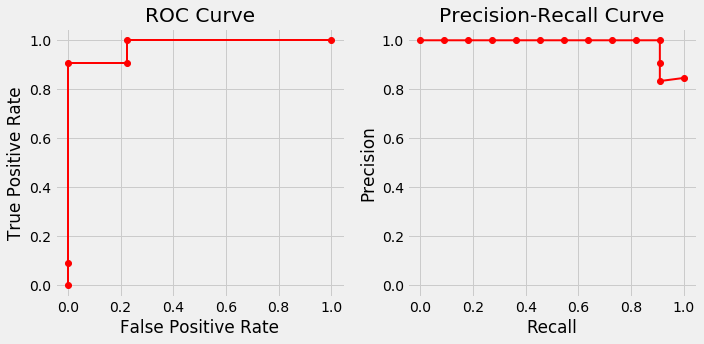

In [60]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

### The Precision Quirk

“How come the PR curve dips to lower precision? Shouldn’t it always go up as we raise the threshold, moving to the left along the curve?”

Glad you asked! This is very annoying and somewhat counterintuitive, but it happens often, so let us take a closer look at it. To illustrate why this happens, we will plot the probability lines for three distinct thresholds: 0.4, 0.5, and 0.57.

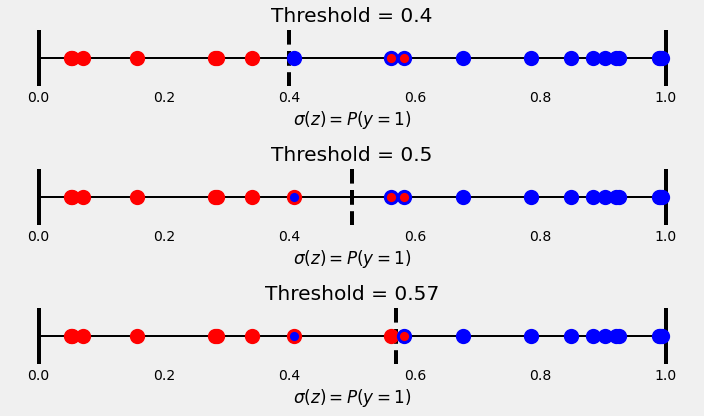

In [55]:
fig = figure19(y_val, probabilities_val)

At the top, with a threshold of 0.4, we have 15 points on the right (classified as positive), two of which are false positives. The precision is given by:

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

But if we move the threshold to the right, up to 0.5, we lose one true positive, effectively reducing precision:

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

This is a temporary side effect though. As we raise the threshold even further to 0.57, we have the benefit of getting rid of a false positive, thus increasing precision:

$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

> In general, raising the threshold will reduce the number of false positives and increase precision.
But, along the way, we may lose some of the true positives, which will temporarily reduce precision. Quirky, right?

### Best and Worst Curves

Let us ask ourselves: what would the best possible (and the worst possible) curves look like?

The best curve belongs to a model that predicts everything perfectly; it gives us a 100% probability to all actual positive data points and 0% probability to all actual negative data points. Of course, such a model does not exist in real life. But cheating does exist. So, let us cheat and use the true labels as the probabilities. These are the curves we get:



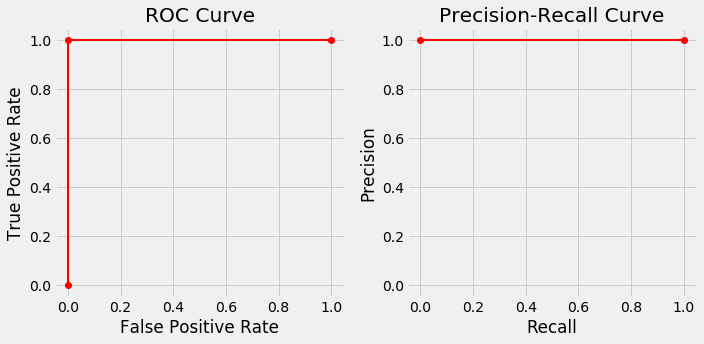

In [62]:
# Best
fig = figure20(y_val)

Nice! If a perfect model exists, its curves are actually squares! The top-left corner on the ROC curve, as well as the top-right corner on the PR curve, are the (unattainable) sweet spots. Our logistic regression was not bad actually. But, of course, our validation set was straightforward.

If a model spits out probabilities all over the place, without any regard to the actual data, it is as bad as it can be. We can simply generate uniformly distributed values between zero and one as our random probabilities:

In [56]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [58]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)


print("FPR:", fpr_random, "\nTPR:", tpr_random)
print("\nPrec:", prec_random, "\nRec:", rec_random)

FPR: [0.         0.         0.22222222 0.22222222 0.33333333 0.33333333
 0.44444444 0.44444444 0.66666667 0.66666667 0.88888889 0.88888889
 1.        ] 
TPR: [0.         0.09090909 0.09090909 0.18181818 0.18181818 0.27272727
 0.27272727 0.54545455 0.54545455 0.90909091 0.90909091 1.
 1.        ]

Prec: [0.57894737 0.55555556 0.58823529 0.625      0.6        0.57142857
 0.53846154 0.5        0.54545455 0.6        0.55555556 0.5
 0.42857143 0.5        0.4        0.5        0.33333333 0.5
 1.         1.        ] 
Rec: [1.         0.90909091 0.90909091 0.90909091 0.81818182 0.72727273
 0.63636364 0.54545455 0.54545455 0.54545455 0.45454545 0.36363636
 0.27272727 0.27272727 0.18181818 0.18181818 0.09090909 0.09090909
 0.09090909 0.        ]


We only have 20 data points, so our curves are not as bad as they theoretically are. The black dashed lines are the theoretical worst for both curves. On the left, the diagonal line is as bad as it can be. On the right, it is a bit more nuanced. The worst is a horizontal line, but the level is given by the proportion of positive samples in the dataset. In our example, we have 11 positive examples out of 20 data points, so the line sits at the level of 0.55.

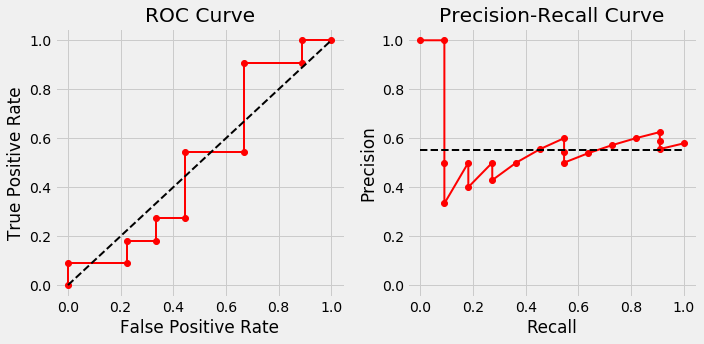

In [65]:
# Worst
fig = figure21(y_val, random_probs)

### Comparing Models

How do you compare curves? The closer they are to squares, the better they are. Besides, if one curve has all its points above all the points of another curve, the one above is clearly the best. The problem is that two different models may produce curves that intersect each other at some point. If that is the case, there is no clear winner.

One possible solution to this dilemma is to look at the area under the curve. The curve with more area under it wins! Luckily, Scikit-Learn has an auc (area under the curve) method, which we can be used to compute the area under the curves for our (good) model:

In [59]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


Very close to the perfect value of one! But then again, this is a toy example. You should not expect figures that are so high in real-life problems.

What about the random model? The theoretical minimum for the area under the worst ROC curve is 0.5, which is the area under the diagonal. The theoretical minimum for the area under the worst PR curve is the proportion of positive samples in the dataset, which is 0.55 in our case. This can be observed by running the following code:

In [67]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941


## Putting It All Together

In this chapter, we have not modified the training pipeline much. The data preparation part is roughly the same as in the previous chapter except that we performed the split using Scikit-Learn this time. The model configuration part is primarily the same as well, but we changed the loss function, so it is appropriate now for a classification problem. The model training part is quite straightforward since the development of the StepByStep class in the last chapter.

But now, after training a model, we can use our class’ predict method to get predictions for our validation set, and use Scikit-Learn’s metrics module to compute a wide range of classification metrics like the confusion matrix.

Behold your pipeline:

### Data preparation

The major difference from the previous version was that we used a dataset that is already split into training and validation sets. This can also be observed in the given code below:

In [61]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Model configuration
In the model configuration part, we only needed to define a model, an appropriate loss function, and an optimizer where our model would be having a single layer and the optimizer will be the same SGD optimizer that we were using before.

In [69]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

### Model training
This part was mostly the same as the previous lesson.

In [62]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

Inspecting the model’s state gives us:

In [71]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1822, -1.8684]], device='cuda:0')), ('linear.bias', tensor([-0.0587], device='cuda:0'))])


### Model evaluation
One additional step that we did over here was evaluating the results of our model, which can be observed by the code given below:

In [72]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])